# Credits predicting - MSHP competition 2023 S211

# Import libraries

In [198]:
# Data
import pandas as pd
import numpy as np

## Drawing
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

## Train, test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from catboost import cv, Pool

## Impute data
from sklearn.impute import SimpleImputer

## Normalize data
from sklearn.preprocessing import MinMaxScaler

# ML
## Models
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

## Params selection
from sklearn.model_selection import GridSearchCV

ignore warnings

In [137]:
import warnings
warnings.filterwarnings("ignore")

# Data preprocess

In [138]:
df_train = pd.read_csv('./datasets/credit_train.csv')
df_test = pd.read_csv('./datasets/credit_test.csv')

In [139]:
df_train

,id,gender,age,marital_status,credit_sum,credit_month,tariff_id,education,credit_count,overdue_credit_count,job_pos,credit_score,region,income,opened
0,26031,M,24,UNM,"24000,00",10,1.60,SCH,2.0,0.0,SPC,"0,728851",ОБЛ ЛЕНИНГРАДСКАЯ,35000.0,True
1,148877,M,23,UNM,"16339,00",18,1.10,SCH,2.0,0.0,SPC,"0,347385",МОСКВА Г,38000.0,True
2,142019,M,54,UNM,"15652,00",10,1.32,GRD,2.0,0.0,SPC,"0,349705",ОБЛ МОСКОВСКАЯ,38000.0,True
3,146816,F,52,UNM,"16560,00",10,1.10,SCH,1.0,0.0,SPC,"0,359232",РЕСП МОРДОВИЯ,28000.0,False
4,27699,F,63,WID,"9078,00",18,1.10,SCH,4.0,0.0,SPC,"0,529368",ЧЕЛЯБИНСКАЯ ОБЛ,30000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,119880,M,29,MAR,"29678,00",10,1.60,GRD,1.0,0.0,SPC,"0,721156",ОМСКАЯ ОБЛАСТЬ,25000.0,False
114395,103695,M,29,MAR,"23068,00",15,1.10,GRD,3.0,0.0,SPC,"0,566393",ТЮМЕНСКАЯ ОБЛ,30000.0,True
114396,131933,F,45,MAR,"16418,00",10,1.10,SCH,1.0,0.0,UMN,"0,327380",ОБЛ БРЯНСКАЯ,30400.0,False
114397,146868,F,49,MAR,"12169,00",10,1.40,SCH,1.0,0.0,SPC,"0,467395",ТАМБОВСКАЯ ОБЛ,16000.0,False


array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'credit_month'}>],
       [<Axes: title={'center': 'tariff_id'}>,
        <Axes: title={'center': 'credit_count'}>,
        <Axes: title={'center': 'overdue_credit_count'}>],
       [<Axes: title={'center': 'income'}>, <Axes: >, <Axes: >]],
      dtype=object)

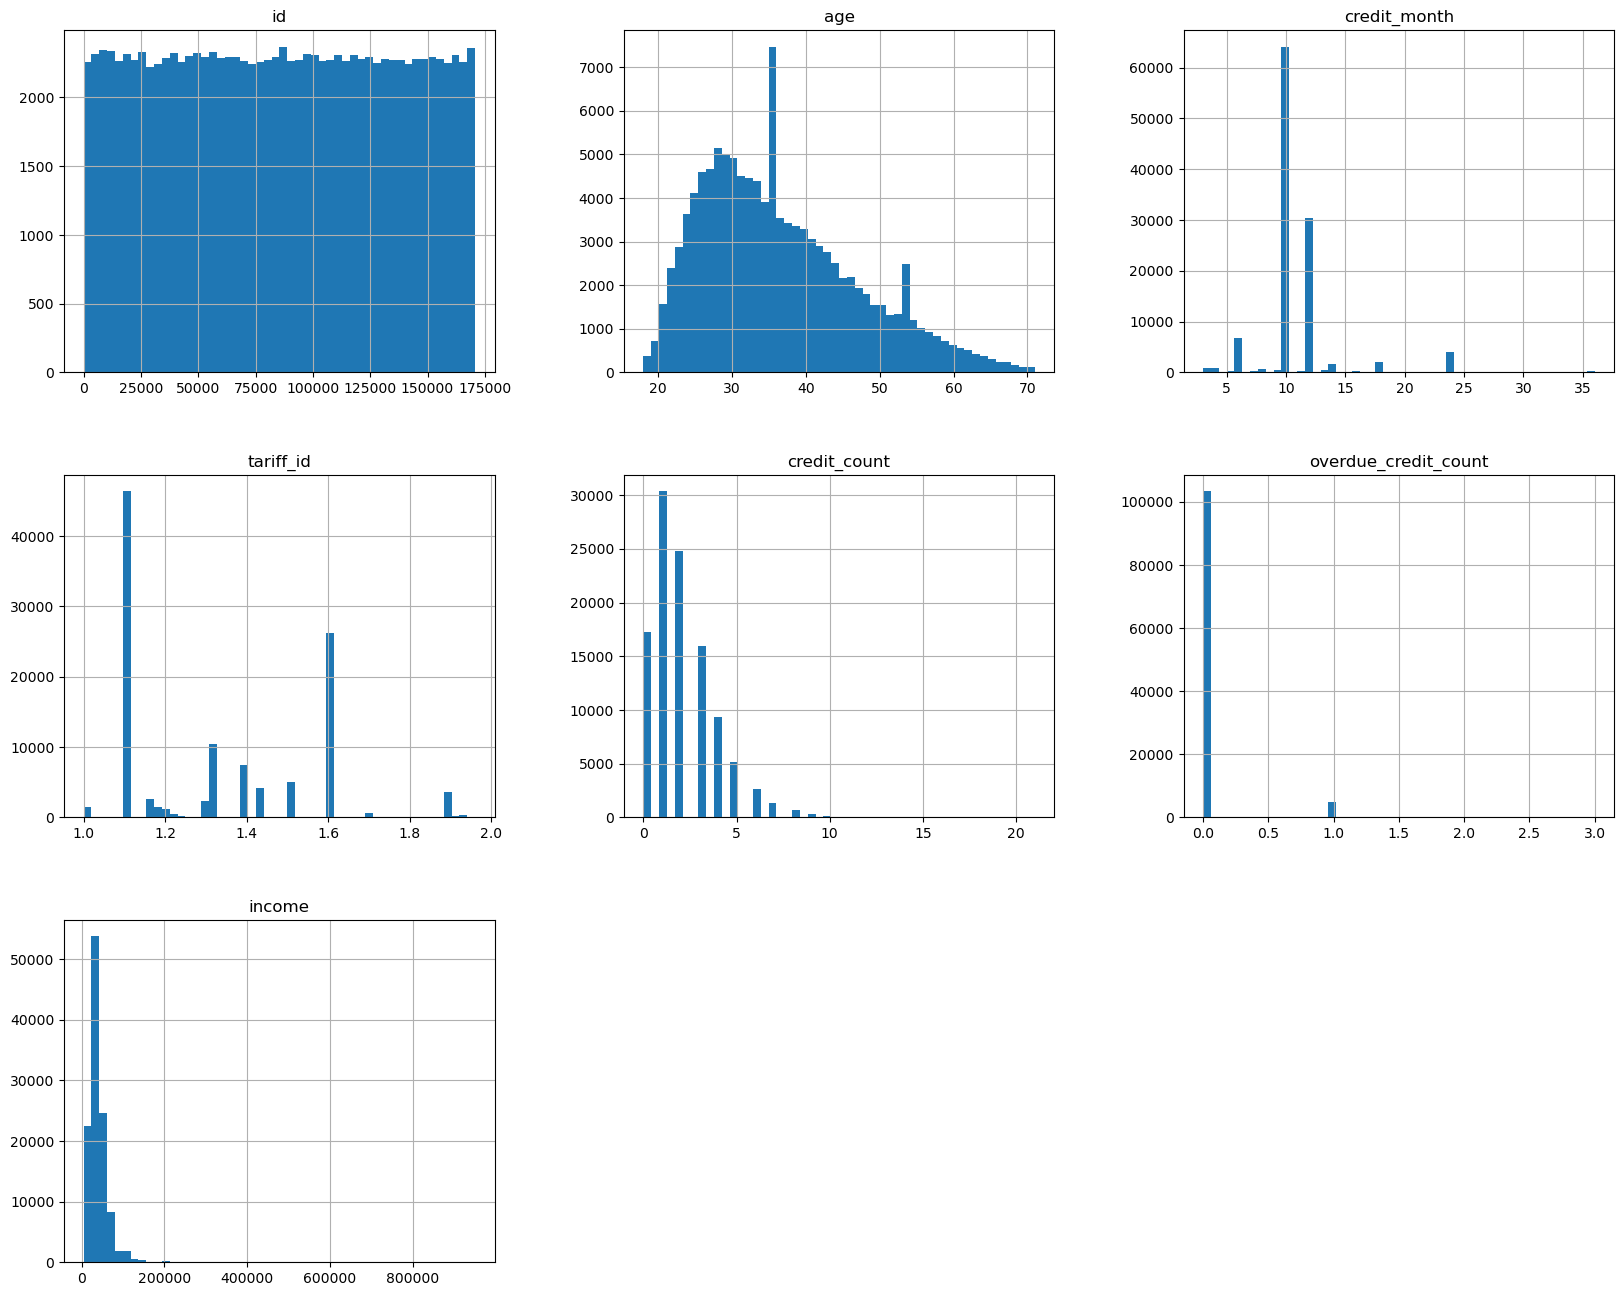

In [140]:
df_train.hist(bins=50, figsize=(20, 16))

Видим что некоторые "числа" записаны через запятую - не круто. Удалим id никакого смысла не несет :/
НО!!! tariff_id не выкидываем это номер тарифа поэтому может сослужит службу

Стратификацию делать стоит, потому что кроме credit_score все признаки распределены не ровно, поэтому стоит хоть как то выровнять выборку

In [141]:
df_train.drop(columns = ['id'], axis=1, inplace=True)
df_test.drop(columns = ['id'], axis=1, inplace=True)
# df_train.drop(columns = ['tariff_id'], axis=1, inplace=True)
# df_test.drop(columns = ['tariff_id'], axis=1, inplace=True)

In [142]:
df_train

,gender,age,marital_status,credit_sum,credit_month,tariff_id,education,credit_count,overdue_credit_count,job_pos,credit_score,region,income,opened
0,M,24,UNM,"24000,00",10,1.60,SCH,2.0,0.0,SPC,"0,728851",ОБЛ ЛЕНИНГРАДСКАЯ,35000.0,True
1,M,23,UNM,"16339,00",18,1.10,SCH,2.0,0.0,SPC,"0,347385",МОСКВА Г,38000.0,True
2,M,54,UNM,"15652,00",10,1.32,GRD,2.0,0.0,SPC,"0,349705",ОБЛ МОСКОВСКАЯ,38000.0,True
3,F,52,UNM,"16560,00",10,1.10,SCH,1.0,0.0,SPC,"0,359232",РЕСП МОРДОВИЯ,28000.0,False
4,F,63,WID,"9078,00",18,1.10,SCH,4.0,0.0,SPC,"0,529368",ЧЕЛЯБИНСКАЯ ОБЛ,30000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,M,29,MAR,"29678,00",10,1.60,GRD,1.0,0.0,SPC,"0,721156",ОМСКАЯ ОБЛАСТЬ,25000.0,False
114395,M,29,MAR,"23068,00",15,1.10,GRD,3.0,0.0,SPC,"0,566393",ТЮМЕНСКАЯ ОБЛ,30000.0,True
114396,F,45,MAR,"16418,00",10,1.10,SCH,1.0,0.0,UMN,"0,327380",ОБЛ БРЯНСКАЯ,30400.0,False
114397,F,49,MAR,"12169,00",10,1.40,SCH,1.0,0.0,SPC,"0,467395",ТАМБОВСКАЯ ОБЛ,16000.0,False


In [143]:
df_train['credit_sum'] = df_train['credit_sum'].map(lambda x: x.replace(',', '.'))
df_train['credit_score'] = df_train['credit_score'].map(lambda x: x.replace(',', '.'))

df_train['credit_sum'] = df_train['credit_sum'].astype(dtype=np.float64)
df_train['credit_score'] = df_train['credit_score'].astype(dtype=np.float64)

df_train['opened'] = df_train['opened'].astype(dtype=np.int64)

In [144]:
df_test['credit_sum'] = df_test['credit_sum'].map(lambda x: x.replace(',', '.'))
df_test['credit_score'] = df_test['credit_score'].map(lambda x: x.replace(',', '.'))

df_test['credit_sum'] = df_test['credit_sum'].astype(dtype=np.float64)
df_test['credit_score'] = df_test['credit_score'].astype(dtype=np.float64)

## Выделим категориальные и числовые признаки

In [145]:
categorical_train = df_train.select_dtypes(include=[object])
number_train = df_train.select_dtypes(include=[int, float, bool])

In [146]:
categorical_train = pd.concat([categorical_train, number_train['tariff_id']], axis=1)
number_train.drop(columns=['tariff_id'], inplace=True)

In [147]:
categorical_train['tariff_id'] = categorical_train['tariff_id'].map(lambda x: str(x))

In [148]:
categorical_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114399 entries, 0 to 114398
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   gender          114399 non-null  object
 1   marital_status  114399 non-null  object
 2   education       114399 non-null  object
 3   job_pos         114399 non-null  object
 4   region          114267 non-null  object
 5   tariff_id       114399 non-null  object
dtypes: object(6)
memory usage: 5.2+ MB


In [149]:
number_train

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,opened
0,24,24000.0,10,2.0,0.0,0.728851,35000.0,1
1,23,16339.0,18,2.0,0.0,0.347385,38000.0,1
2,54,15652.0,10,2.0,0.0,0.349705,38000.0,1
3,52,16560.0,10,1.0,0.0,0.359232,28000.0,0
4,63,9078.0,18,4.0,0.0,0.529368,30000.0,0
...,...,...,...,...,...,...,...,...
114394,29,29678.0,10,1.0,0.0,0.721156,25000.0,0
114395,29,23068.0,15,3.0,0.0,0.566393,30000.0,1
114396,45,16418.0,10,1.0,0.0,0.327380,30400.0,0
114397,49,12169.0,10,1.0,0.0,0.467395,16000.0,0


In [150]:
df_train.isna().sum()

gender                     0
age                        0
marital_status             0
credit_sum                 0
credit_month               0
tariff_id                  0
education                  0
credit_count            6189
overdue_credit_count    6189
job_pos                    0
credit_score               0
region                   132
income                     0
opened                     0
dtype: int64

In [151]:
df_train['region'].value_counts()

region
ОБЛ МОСКОВСКАЯ                   8192
КРАСНОДАРСКИЙ КРАЙ               5010
САНКТ-ПЕТЕРБУРГ                  3751
МОСКВА                           3706
ТАТАРСТАН РЕСП                   3455
                                 ... 
ОБЛ.РОСТОВСКАЯ                      1
ОМСКАЯ                              1
РЕСП. КОМИ                          1
ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ       1
ТОМСКАЯ                             1
Name: count, Length: 284, dtype: int64

## Impute nans

In [152]:
imp_median = SimpleImputer(strategy='median')

In [153]:
imp_median.fit(number_train)

SimpleImputer(strategy='median')

In [154]:
number_train_imputed = pd.DataFrame(imp_median.transform(number_train), columns=number_train.columns)

In [155]:
number_train_imputed

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,opened
0,24.0,24000.0,10.0,2.0,0.0,0.728851,35000.0,1.0
1,23.0,16339.0,18.0,2.0,0.0,0.347385,38000.0,1.0
2,54.0,15652.0,10.0,2.0,0.0,0.349705,38000.0,1.0
3,52.0,16560.0,10.0,1.0,0.0,0.359232,28000.0,0.0
4,63.0,9078.0,18.0,4.0,0.0,0.529368,30000.0,0.0
...,...,...,...,...,...,...,...,...
114394,29.0,29678.0,10.0,1.0,0.0,0.721156,25000.0,0.0
114395,29.0,23068.0,15.0,3.0,0.0,0.566393,30000.0,1.0
114396,45.0,16418.0,10.0,1.0,0.0,0.327380,30400.0,0.0
114397,49.0,12169.0,10.0,1.0,0.0,0.467395,16000.0,0.0


In [156]:
categorical_train.fillna('ОБЛ МОСКОВСКАЯ', inplace=True)

## Normalize

In [157]:
scaler = MinMaxScaler()

In [158]:
number_train_imputed = pd.DataFrame(scaler.fit_transform(number_train_imputed), columns=number_train_imputed.columns)

In [159]:
number_train_imputed

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,opened
0,0.113208,0.107795,0.212121,0.095238,0.0,0.645978,0.031746,1.0
1,0.094340,0.068958,0.454545,0.095238,0.0,0.307886,0.034921,1.0
2,0.679245,0.065476,0.212121,0.095238,0.0,0.309942,0.034921,1.0
3,0.641509,0.070079,0.212121,0.047619,0.0,0.318386,0.024339,0.0
4,0.849057,0.032150,0.454545,0.190476,0.0,0.469177,0.026455,0.0
...,...,...,...,...,...,...,...,...
114394,0.207547,0.136578,0.212121,0.047619,0.0,0.639158,0.021164,0.0
114395,0.207547,0.103070,0.363636,0.142857,0.0,0.501992,0.026455,1.0
114396,0.509434,0.069359,0.212121,0.047619,0.0,0.290156,0.026878,0.0
114397,0.584906,0.047819,0.212121,0.047619,0.0,0.414250,0.011640,0.0


## New features

### Описание фичей
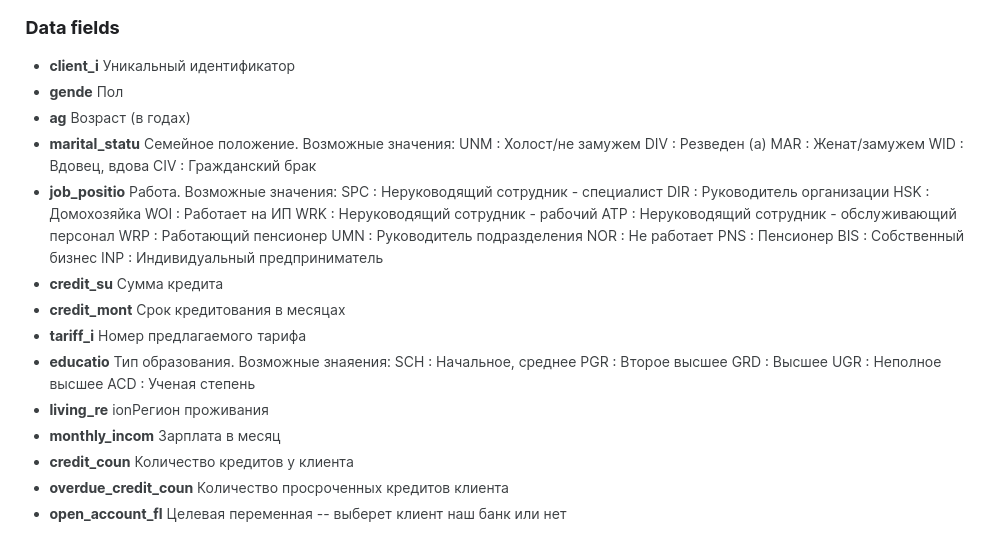

In [160]:
number_train_imputed.corr()['opened']

age                    -0.034788
credit_sum             -0.069257
credit_month            0.027354
credit_count            0.029789
overdue_credit_count    0.013779
credit_score            0.049692
income                 -0.021387
opened                  1.000000
Name: opened, dtype: float64

In [161]:
number_train_imputed['factor'] = number_train_imputed['income'] * number_train_imputed['credit_month'] / number_train_imputed['credit_sum']

In [162]:
number_train_imputed.corr()['opened'].sort_values()

credit_sum             -0.069257
age                    -0.034788
income                 -0.021387
overdue_credit_count    0.013779
credit_month            0.027354
credit_count            0.029789
factor                  0.035149
credit_score            0.049692
opened                  1.000000
Name: opened, dtype: float64

Новые признак факторности оплаты кредита - бомба. За одно действие топовый признак)

## One-Hot Encode

In [163]:
categorical_train_encoded = pd.get_dummies(categorical_train).astype(dtype=np.int32)

In [164]:
categorical_train_encoded

,gender_F,gender_M,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID,education_ACD,education_GRD,education_PGR,...,tariff_id_1.48,tariff_id_1.5,tariff_id_1.52,tariff_id_1.56,tariff_id_1.6,tariff_id_1.7,tariff_id_1.9,tariff_id_1.91,tariff_id_1.94,tariff_id_1.96
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
114395,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
114396,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114397,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Concatenate 2 dataframes

In [197]:
df_train_prepared = pd.concat([number_train_imputed, categorical_train_encoded], axis=1)
df_train_cat = pd.concat([number_train_imputed, categorical_train], axis=1)

In [203]:
df_train_cat

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,opened,factor,gender,marital_status,education,job_pos,region,tariff_id
0,0.113208,0.107795,0.212121,0.095238,0.0,0.645978,0.031746,1.0,0.062471,M,UNM,SCH,SPC,ОБЛ ЛЕНИНГРАДСКАЯ,1.6
1,0.094340,0.068958,0.454545,0.095238,0.0,0.307886,0.034921,1.0,0.230183,M,UNM,SCH,SPC,МОСКВА Г,1.1
2,0.679245,0.065476,0.212121,0.095238,0.0,0.309942,0.034921,1.0,0.113132,M,UNM,GRD,SPC,ОБЛ МОСКОВСКАЯ,1.32
3,0.641509,0.070079,0.212121,0.047619,0.0,0.318386,0.024339,0.0,0.073671,F,UNM,SCH,SPC,РЕСП МОРДОВИЯ,1.1
4,0.849057,0.032150,0.454545,0.190476,0.0,0.469177,0.026455,0.0,0.374031,F,WID,SCH,SPC,ЧЕЛЯБИНСКАЯ ОБЛ,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,0.207547,0.136578,0.212121,0.047619,0.0,0.639158,0.021164,0.0,0.032870,M,MAR,GRD,SPC,ОМСКАЯ ОБЛАСТЬ,1.6
114395,0.207547,0.103070,0.363636,0.142857,0.0,0.501992,0.026455,1.0,0.093335,M,MAR,GRD,SPC,ТЮМЕНСКАЯ ОБЛ,1.1
114396,0.509434,0.069359,0.212121,0.047619,0.0,0.290156,0.026878,0.0,0.082202,F,MAR,SCH,UMN,ОБЛ БРЯНСКАЯ,1.1
114397,0.584906,0.047819,0.212121,0.047619,0.0,0.414250,0.011640,0.0,0.051635,F,MAR,SCH,SPC,ТАМБОВСКАЯ ОБЛ,1.4


In [166]:
df_train_prepared

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,opened,factor,gender_F,...,tariff_id_1.48,tariff_id_1.5,tariff_id_1.52,tariff_id_1.56,tariff_id_1.6,tariff_id_1.7,tariff_id_1.9,tariff_id_1.91,tariff_id_1.94,tariff_id_1.96
0,0.113208,0.107795,0.212121,0.095238,0.0,0.645978,0.031746,1.0,0.062471,0,...,0,0,0,0,1,0,0,0,0,0
1,0.094340,0.068958,0.454545,0.095238,0.0,0.307886,0.034921,1.0,0.230183,0,...,0,0,0,0,0,0,0,0,0,0
2,0.679245,0.065476,0.212121,0.095238,0.0,0.309942,0.034921,1.0,0.113132,0,...,0,0,0,0,0,0,0,0,0,0
3,0.641509,0.070079,0.212121,0.047619,0.0,0.318386,0.024339,0.0,0.073671,1,...,0,0,0,0,0,0,0,0,0,0
4,0.849057,0.032150,0.454545,0.190476,0.0,0.469177,0.026455,0.0,0.374031,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,0.207547,0.136578,0.212121,0.047619,0.0,0.639158,0.021164,0.0,0.032870,0,...,0,0,0,0,1,0,0,0,0,0
114395,0.207547,0.103070,0.363636,0.142857,0.0,0.501992,0.026455,1.0,0.093335,0,...,0,0,0,0,0,0,0,0,0,0
114396,0.509434,0.069359,0.212121,0.047619,0.0,0.290156,0.026878,0.0,0.082202,1,...,0,0,0,0,0,0,0,0,0,0
114397,0.584906,0.047819,0.212121,0.047619,0.0,0.414250,0.011640,0.0,0.051635,1,...,0,0,0,0,0,0,0,0,0,0


In [167]:
df_train_prepared.isna().sum()

age                     0
credit_sum              0
credit_month            0
credit_count            0
overdue_credit_count    0
                       ..
tariff_id_1.7           0
tariff_id_1.9           0
tariff_id_1.91          0
tariff_id_1.94          0
tariff_id_1.96          0
Length: 355, dtype: int64

## Stratified shuffle

Применим стратификацию, потому что выборка явно не сбалансированная

In [168]:
split = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=42)
for train_index, test_index in split.split(df_train_prepared, df_train_prepared['opened']):
    strat_train_set = df_train_prepared.loc[train_index]
    strat_test_set = df_train_prepared.loc[test_index]

In [169]:
y_strat = strat_train_set['opened']
X_strat = strat_train_set.drop(columns=['opened'], axis=1)

In [175]:
X_strat.replace([np.inf, -np.inf], 0, inplace=True)
X_strat = X_strat.astype(dtype=np.float128)

In [204]:
X_catboost = df_train_cat.drop(axis=1, columns=['opened'])
y_catboost = df_train_cat['opened']

In [205]:
X_catboost

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,factor,gender,marital_status,education,job_pos,region,tariff_id
0,0.113208,0.107795,0.212121,0.095238,0.0,0.645978,0.031746,0.062471,M,UNM,SCH,SPC,ОБЛ ЛЕНИНГРАДСКАЯ,1.6
1,0.094340,0.068958,0.454545,0.095238,0.0,0.307886,0.034921,0.230183,M,UNM,SCH,SPC,МОСКВА Г,1.1
2,0.679245,0.065476,0.212121,0.095238,0.0,0.309942,0.034921,0.113132,M,UNM,GRD,SPC,ОБЛ МОСКОВСКАЯ,1.32
3,0.641509,0.070079,0.212121,0.047619,0.0,0.318386,0.024339,0.073671,F,UNM,SCH,SPC,РЕСП МОРДОВИЯ,1.1
4,0.849057,0.032150,0.454545,0.190476,0.0,0.469177,0.026455,0.374031,F,WID,SCH,SPC,ЧЕЛЯБИНСКАЯ ОБЛ,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,0.207547,0.136578,0.212121,0.047619,0.0,0.639158,0.021164,0.032870,M,MAR,GRD,SPC,ОМСКАЯ ОБЛАСТЬ,1.6
114395,0.207547,0.103070,0.363636,0.142857,0.0,0.501992,0.026455,0.093335,M,MAR,GRD,SPC,ТЮМЕНСКАЯ ОБЛ,1.1
114396,0.509434,0.069359,0.212121,0.047619,0.0,0.290156,0.026878,0.082202,F,MAR,SCH,UMN,ОБЛ БРЯНСКАЯ,1.1
114397,0.584906,0.047819,0.212121,0.047619,0.0,0.414250,0.011640,0.051635,F,MAR,SCH,SPC,ТАМБОВСКАЯ ОБЛ,1.4


# ML

## LogisticRegression

In [176]:
lr = LogisticRegression(dual=False, max_iter=2_000_000, n_jobs=-1, multi_class='ovr')

In [189]:
params = {
    'C': np.arange(2, 20, 0.1),
    'penalty': ['l2'],
    'solver': ['newton-cholesky'],
    # 'l1_ratio': [0.1, 0.5, 1],
}

In [190]:
gs = GridSearchCV(lr, params, scoring='f1', n_jobs=-1, cv=5, verbose=2)

In [191]:
gs.fit(X_strat, y_strat)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END ..........C=2.2, penalty=l2, solver=newton-cholesky; total time=  13.6s
[CV] END ..........C=2.1, penalty=l2, solver=newton-cholesky; total time=  13.7s
[CV] END C=2.3000000000000003, penalty=l2, solver=newton-cholesky; total time=  13.8s
[CV] END C=2.3000000000000003, penalty=l2, solver=newton-cholesky; total time=  14.2s
[CV] END ..........C=2.1, penalty=l2, solver=newton-cholesky; total time=  14.4s
[CV] END ..........C=2.2, penalty=l2, solver=newton-cholesky; total time=  14.5s
[CV] END ..........C=2.0, penalty=l2, solver=newton-cholesky; total time=  14.6s
[CV] END ..........C=2.0, penalty=l2, solver=newton-cholesky; total time=  14.6s
[CV] END C=2.3000000000000003, penalty=l2, solver=newton-cholesky; total time=  14.5s
[CV] END C=2.4000000000000004, penalty=l2, solver=newton-cholesky; total time=  14.4s
[CV] END C=2.4000000000000004, penalty=l2, solver=newton-cholesky; total time=  14.5s
[CV] END C=2.40000000

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=2000000, multi_class='ovr',
                                          n_jobs=-1),
             n_jobs=-1,
             param_grid={'C': array([ 2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,
        3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,
        4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,
        5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,
        6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,
        7.5,  7.6,  7....
       14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1,
       15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16. , 16.1, 16.2,
       16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17. , 17.1, 17.2, 17.3,
       17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18. , 18.1, 18.2, 18.3, 18.4,
       18.5, 18.6, 18.7, 18.8, 18.9, 19. , 19.1, 19.2, 19.3, 19.4, 19.5,
       19.6, 19.7, 19.8, 19.9]),
                         'penalty': ['l2'], 'solver': ['newton-cholesky']},
             scoring='f1', verbose=2)

In [193]:
gs.best_score_, gs.best_params_

(0.10740992746005602,
 {'C': 10.500000000000007, 'penalty': 'l2', 'solver': 'newton-cholesky'})

Логистическая регрессия не оправдала надежд) Забудем как страшный сон)))

## CatBoost)

In [195]:
model = CatBoostClassifier(iterations=2_000_000, task_type='GPU')

In [206]:
cv_dataset = Pool(data=X_catboost, label=y_catboost)

AttributeError: 'DataFrame' object has no attribute 'iteritems'

In [196]:
model.fit(X_strat, y_strat)

AttributeError: 'DataFrame' object has no attribute 'iteritems'